In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
navoneel_brain_mri_images_for_brain_tumor_detection_path = kagglehub.dataset_download('navoneel/brain-mri-images-for-brain-tumor-detection')

print('Data source import complete.')


100%|██████████| 15.1M/15.1M [00:00<00:00, 103MB/s] 

Extracting files...


Data source import complete.


# **Import needed modules**

In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# **Data Preprocessing**

### **Read data and store it in dataframe**


In [4]:
# Generate data paths with labels
import kagglehub

# Download latest version
path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")

print("Path to dataset files:", path)
filepaths = []
labels = []
data_dir = "/kaggle/input/brain-mri-images-for-brain-tumor-detection"

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

Path to dataset files: /kaggle/input/brain-mri-images-for-brain-tumor-detection


In [5]:
df

,filepaths,labels
0,/kaggle/input/brain-mri-images-for-brain-tumor...,no
1,/kaggle/input/brain-mri-images-for-brain-tumor...,no
2,/kaggle/input/brain-mri-images-for-brain-tumor...,no
3,/kaggle/input/brain-mri-images-for-brain-tumor...,no
4,/kaggle/input/brain-mri-images-for-brain-tumor...,no
...,...,...
250,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
251,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
252,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
253,/kaggle/input/brain-mri-images-for-brain-tumor...,brain_tumor_dataset


In [6]:
df.loc[253]

,253
filepaths,/kaggle/input/brain-mri-images-for-brain-tumor...
labels,brain_tumor_dataset


### **Split Data into train, test, and valid**

In [7]:
strat = df["labels"]
train_df, test_df = train_test_split(df, train_size= 0.8, shuffle= True, random_state=123, stratify= strat)

In [8]:
train_df

,filepaths,labels
14,/kaggle/input/brain-mri-images-for-brain-tumor...,no
213,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
33,/kaggle/input/brain-mri-images-for-brain-tumor...,no
53,/kaggle/input/brain-mri-images-for-brain-tumor...,no
64,/kaggle/input/brain-mri-images-for-brain-tumor...,no
...,...,...
21,/kaggle/input/brain-mri-images-for-brain-tumor...,no
201,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
50,/kaggle/input/brain-mri-images-for-brain-tumor...,no
215,/kaggle/input/brain-mri-images-for-brain-tumor...,yes


In [9]:
test_df

,filepaths,labels
186,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
143,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
175,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
250,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
191,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
142,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
156,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
80,/kaggle/input/brain-mri-images-for-brain-tumor...,no
227,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
113,/kaggle/input/brain-mri-images-for-brain-tumor...,yes


### **Create Image Data Generator**

In [10]:
batch_size = 8
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col="filepaths", y_col= "labels", target_size= img_size, class_mode= "categorical", color_mode= "rgb", shuffle= True, batch_size= batch_size)
test_gen = tr_gen.flow_from_dataframe(test_df, x_col="filepaths", y_col= "labels", target_size= img_size, class_mode= "categorical", color_mode= "rgb", shuffle= False, batch_size= batch_size)

Found 202 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


### **Show Sample from train Data**

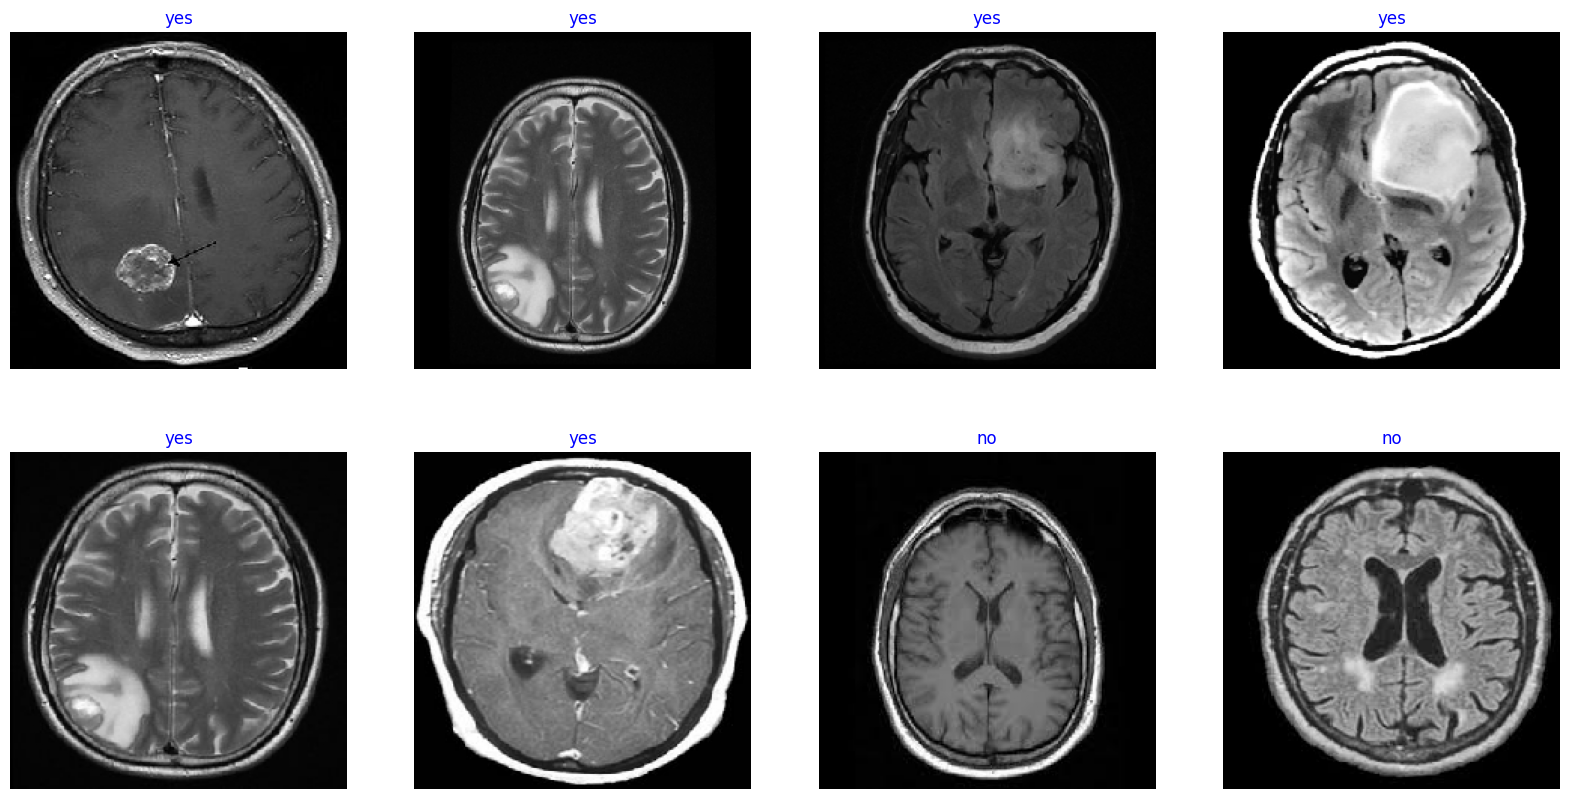

In [11]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize=(20, 10))

for i in range(8):
    plt.subplot(2, 4, i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= "blue", fontsize= 12)
    plt.axis("off")

plt.show()

# **Model Structure**

### **Generic Model Creation**

In [12]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False, weights= "imagenet", input_shape= img_shape, pooling= "max")

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= "softmax")
])
model.compile(Adamax(learning_rate= 0.001), loss= "categorical_crossentropy", metrics= ["accuracy"])
model.summary()


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         3,074 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,792,753 (41.17 MB)

 Trainable params: 10,702,378 (40.83 MB)

 Non-trainable params: 90,375 (353.03 KB)

### **Train Model**

In [24]:
history = model.fit(x= train_gen, epochs= 5, verbose= 1, validation_data= test_gen, validation_steps= None, shuffle= False)

Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.9925 - loss: 0.0481 - val_accuracy: 0.8824 - val_loss: 0.4963
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - accuracy: 0.9738 - loss: 0.0561 - val_accuracy: 0.8824 - val_loss: 0.6546
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.9740 - loss: 0.1031 - val_accuracy: 0.8824 - val_loss: 0.7414
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.9812 - loss: 0.0911 - val_accuracy: 0.8824 - val_loss: 0.6938
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.9638 - loss: 0.1323 - val_accuracy: 0.8627 - val_loss: 0.6032


### **Display Model Performance**

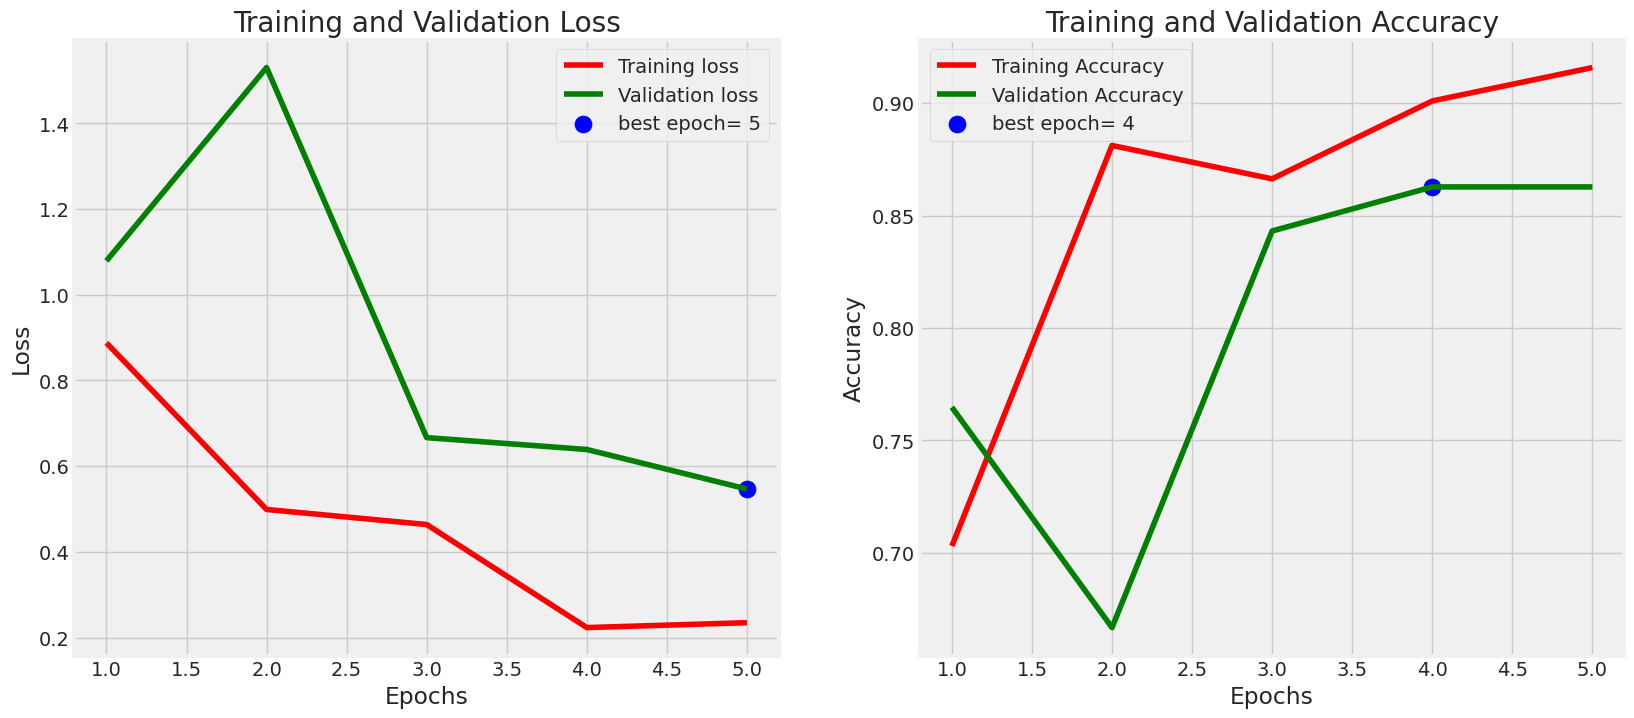

In [15]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

### **Evaluate Model**

In [16]:
train_score = model.evaluate(train_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 812ms/step - accuracy: 0.9746 - loss: 0.1121
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 804ms/step - accuracy: 0.9003 - loss: 0.4837
Train Loss:  0.11779945343732834
Train Accuracy:  0.9603960514068604
--------------------
Test Loss:  0.5466129183769226
Test Accuracy:  0.8627451062202454


### **Get Predections**

In [17]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step


### **Confusion Matrics and Classification Report**


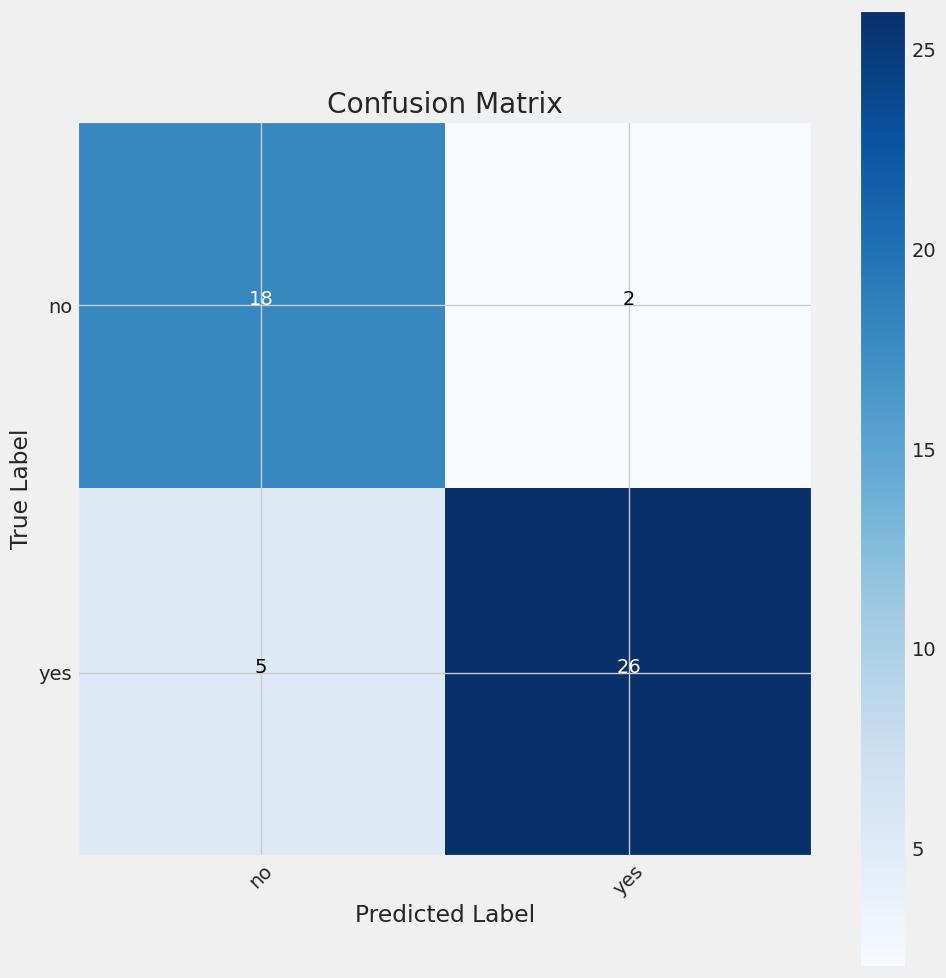

In [18]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [21]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

          no       0.78      0.90      0.84        20
         yes       0.93      0.84      0.88        31

    accuracy                           0.86        51
   macro avg       0.86      0.87      0.86        51
weighted avg       0.87      0.86      0.86        51



### **Save Model**


In [22]:
#Save the model
model.save('Model.h5')